# Current vs Density

In [1]:
import sys
import os
sys.path.insert(0, '../magcolloids')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML, clear_output
import jsonpickle
import scipy.optimize as spo
import scipy.spatial as spa 
import magcolloids as mgc
import matplotlib as mpl
import string as st
import support as sp

from tqdm import tqdm_notebook

ureg = mgc.ureg

idx = pd.IndexSlice

%reload_ext autoreload
%autoreload 2

### Read data

In [2]:
mpl.rc('text', usetex=True)
mpl.rcParams['figure.dpi'] = 150

In [3]:
directory = "Z:/Dimers/Simulations/DensityDependence3/"
index_name = "index.dat"

index = pd.read_csv(os.path.join(directory,index_name),sep=" ", names = ["file","packing"])
index.head()

,file,packing
0,Phi_0.01,0.010000
1,Phi_0.04379746835443038,0.043797
2,Phi_0.021265822784810127,0.021266
3,Phi_0.07759493670886075,0.077595
4,Phi_0.03253164556962025,0.032532


In [4]:
h = 3.9 * ureg.um
tilt_angle = 7*ureg.deg
frequency = 3*ureg.Hz

In [5]:
diff_vel = [pd.read_csv(os.path.join(directory,name.file+"_vupdown.dat"), sep="\t",index_col = 0)
            for i,name in tqdm_notebook(index.loc[:].iterrows())]

In [6]:
diff_vel_pd = pd.concat(diff_vel, keys = index.index, names=["file"])
diff_vel_pd.loc[:,"packing"] = index.loc[diff_vel_pd.index.get_level_values("file")].packing.values
diff_vel_pd["plane"] = diff_vel_pd.index.get_level_values("plane")
diff_vel_pd = diff_vel_pd.set_index(["packing","plane"])
diff_vel_pd.head()

x         y
packing  plane                    
0.010000 down  -0.005588  0.008828
0.043797 down   0.005599  0.004297
0.021266 down   0.000516 -0.010277
0.077595 down  -0.008814 -0.000400
         up    -0.312785  3.433837

In [7]:
d = 2.8
freq = frequency.magnitude

def calc_current(series):
    phi = series.index.get_level_values("packing").unique().values[0]
    factor = freq*d*np.sqrt(np.pi/np.sqrt(3)/phi)
    
    if any(series.index.get_level_values("plane")=="up") & \
            any(series.index.get_level_values("plane")=="down"):
        
        out = series.loc[idx[:,"up"],:].reset_index(level=1,drop=True) - \
            series.loc[idx[:,"down"],:].reset_index(level=1,drop=True)

        return pd.DataFrame(data = [np.sqrt(out.x.values**2+out.y.values**2)/(factor)], columns = ["I"])
    else:
    
        return pd.DataFrame(data = [series.index.get_level_values("packing").unique()*0], columns = ["I"])
    

In [8]:
current = diff_vel_pd.groupby("packing").apply(calc_current).reset_index(level=1,drop=True)

In [9]:
current.to_csv("current_vs_density.dat",sep="\t")

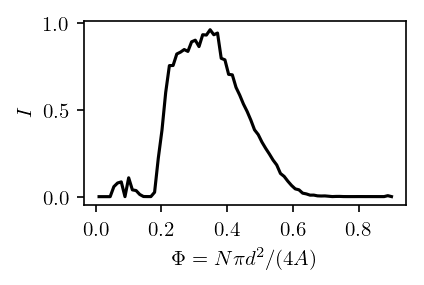

In [12]:
fig = plt.figure(figsize=(3,2))
plt.plot(current.index, current.I, color="black")
plt.xlabel(r"$\Phi = N\pi d^2 / (4A)$")
plt.ylabel(r"$I$")
fig.tight_layout()
fig.savefig('current_jamming.pdf', pad_inches = 0, bbox_inches = "tight")

In [11]:
current.to_csv("current_vs_packing",sep="\t")

# Video Inspection.
We now produce videos at different points of the density dependence curve to explore the mechanism behind jamming.

In [11]:
Phi = current.index
Phi_video = np.array([0.1,0.3,0.5,0.7])
Phi = Phi[:,np.newaxis]
Phi_video = Phi_video[np.newaxis,:]
chosen_currents = current.iloc[np.argmin(np.abs(np.array(Phi)-Phi_video),axis=0)]

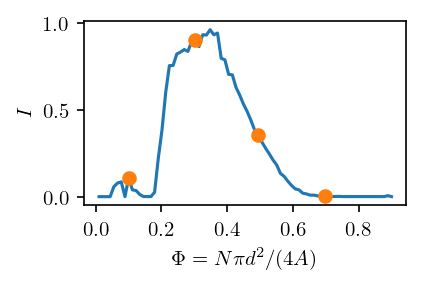

In [12]:
fig = plt.figure(figsize=(3,2))
plt.plot(current.index, current.I)
plt.plot(chosen_currents.index, chosen_currents.I,'o')
plt.xlabel(r"$\Phi = N\pi d^2 / (4A)$")
plt.ylabel(r"$I$")
fig.tight_layout()
fig.savefig('current_jamming.pdf', pad_inches = 0, bbox_inches = "tight")

In [13]:
chosen_index = index[index.packing.isin(chosen_currents.index)]
chosen_index

,file,packing
14,Phi_0.10012658227848101,0.100127
31,Phi_0.3029113924050633,0.302911
43,Phi_0.49443037974683546,0.494430
61,Phi_0.6972151898734177,0.697215


In [14]:
%%time

video_slow = []
video_fast = []

for i in range(len(chosen_index)):
    
    name = chosen_index.iloc[i].loc["file"]

    trj, bounds = sp.load_trj_time_range(name,directory,[10,25])
    video_slow.append(sp.make_video_slowmo(name,trj,bounds))
    video_fast.append(sp.make_video_fastmo(name,trj,bounds))

Wall time: 4min 48s


### At very low packing

In [15]:
i = 0
print(chosen_index.iloc[i].packing)

HTML("""<div class="row">
  <div class="col-sm-6">%s</div>
  <div class="col-sm-6">%s</div>
</div>"""%(video_slow[i],video_fast[i]))

0.100126582278481


At very low packing the system acts as a gas. There is no current because all particles are in the bottom of the cell.

### At intermediate packing

In [16]:
i = 1
print(chosen_index.iloc[i].packing)

HTML("""<div class="row">
  <div class="col-sm-6">%s</div>
  <div class="col-sm-6">%s</div>
</div>"""%(video_slow[i],video_fast[i]))

0.3029113924050633


There is maximum current. The system aranges almost in a regular lattice. 

### At higher packing.

In [17]:
i = 2
print(chosen_index.iloc[i].packing)

HTML("""<div class="row">
  <div class="col-sm-6">%s</div>
  <div class="col-sm-6">%s</div>
</div>"""%(video_slow[i],video_fast[i]))

0.4944303797468354


This system is mostly disordered. The contact interactions between particles do not allow the separation process to take place always in the same direction. 

### At very high packing. 

In [18]:
i = 3
print(chosen_index.iloc[i].packing)

HTML("""<div class="row">
  <div class="col-sm-6">%s</div>
  <div class="col-sm-6">%s</div>
</div>"""%(video_slow[i],video_fast[i]))

0.6972151898734177


At very high packing, the system aranges in an almost hexagonal configuration of vibrating particles. There is no oportunity for directional exchanges. 